In [1]:
# Since training take long, I like to have a voice telling me
# in which step are we in. Totally optional.
import pyttsx3
engine = pyttsx3.init()
voices = engine.getProperty('voices')
engine.setProperty('voice', voices[1].id)
engine.say("I'm ready")
engine.runAndWait()

# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import cv2
import pickle
import os
from collections import Counter, defaultdict
from itertools import product
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, log_loss
from sklearn.model_selection import RepeatedKFold, train_test_split
from functools import partial, lru_cache
from copy import copy
from tqdm import tqdm, tqdm_notebook, notebook
from operator import itemgetter
from PIL import Image
from glob import glob

from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.compiler import transpile, assemble

S_simulator = Aer.backends(name = 'statevector_simulator')[0]
M_simulator = Aer.backends(name = 'qasm_simulator')[0]

%matplotlib inline

# Auxiliar functions definition

In [3]:
def preprocess(vector):
    i_unsigned = np.multiply(-1, vector)
    i_binary = [bin(int(n)) for n in i_unsigned]
    for index, e in enumerate(i_binary):
        if(e[0] == '-'):
            i_binary[index] = [-1, list(map(int, str(int(bin(index)[2:]))))]
        else:
            i_binary[index] = [1, list(map(int, str(int(bin(index)[2:]))))]
            
    n = int(np.log2(len(i_binary)))
    for index, element in enumerate(i_binary):
        if (len(element[1]) != n):
            while (len(i_binary[index][1]) != n):
                i_binary[index][1].insert(0, 0)
    i_binary = np.array(i_binary)
    return i_binary

def check_z(binary):
    positive = True # Controls the sign to achieve
    
    if (int(binary[0][0]) < 0):
        positive = False
    z_index = []
    for index, element in enumerate(binary):
        counts = Counter(element[1])
        if (counts[1] == 1):
            if (positive):
                if (int(binary[index][0]) == -1):
                    z_index.append(int(np.where(np.array(binary[index][1]) == 1)[0][0]))
            else:
                if (int(binary[index][0]) == 1):
                    z_index.append(int(np.where(np.array(binary[index][1]) == 1)[0][0]))
    return z_index

def apply_z(binary, Z):
    for z in Z:
        mask = np.array(list(map(lambda x : x[z] == 1, binary[:,1])))
        binary[mask, 0] *= -1
    return binary


def check_cpz(binary):
    CPZ = set()
    n = int(np.log2(len(binary)))
    sequence = 0
    for p in range(2, n + 1):
        for ind, e in enumerate(binary):
            counts = Counter(e[1])
            if (counts[1] == p) and (binary[0][0] != e[0]):
                ones = np.where(np.array(e[1]) == 1)[0]
                CPZ.add(tuple([sequence, tuple(ones)]))
                sequence += 1
                
                ones_set = set(ones)
                mask = np.array(list(map(partial(check_set, ones_set) , binary[:, 1])))
                
                binary[mask, 0] *= -1
                
    CPZ = [list(ele) for _, ele in enumerate(CPZ)]
    CPZ = sorted(CPZ, key = lambda l: l[0])
    CPZ = [list(e[1]) for e in CPZ]
    return CPZ

def check_set(ones_set, pos_set):
    return set.issubset(ones_set, set(np.where(np.array(pos_set) == 1)[0]))

def vectorize(number, digits):
    digits = 2**(np.ceil(np.log2(digits)))
    binary_number = bin(number)[2:]
    as_text = str(binary_number)
    vectorized_number = [int(d) for d in as_text]
    if (digits < len(vectorized_number)):
        digits = 2**(np.ceil(np.log2(len(vectorized_number))))
    if (digits > len(vectorized_number)):
        while (len(vectorized_number) != digits):
            vectorized_number.insert(0, 0)
    return np.array(vectorized_number)

def o_product(i, w):
    return (np.abs(np.dot(i, w))/len(i))**2

def sign(p):
    return np.array([(-1)**i for i in p])

def design(p):
    return [1 if i < 0 else 0 for i in w]

def reindex(N, change):
    origin = np.array([i for i in range(N)])
    destiny = np.flipud(origin)
    
    for index, element in enumerate(change):
        change[index] = np.where(destiny == element)[0][0]
    return change

def U(qc, q, Z, CPZ):
    for z in Z:
        qc.z(q[int(z)])
    
    for cpz in CPZ:
        controls = [q[int(i)] for i in cpz[:-1]]
        target = q[int(cpz[-1])]
        qc.h(cpz[-1])
        qc.mct(controls, target, None, mode='noancilla')
        qc.h(cpz[-1])
    return qc

#@lru_cache(maxsize = None)
def gates_sequence(vector):
    binary = preprocess(vector.astype('int'))
    Z_GATES = check_z(binary)
    binary = apply_z(binary, Z_GATES)
    CPZ_GATES = check_cpz(binary)
    return Z_GATES, CPZ_GATES

def perceptron(N = 1, shots = 512, z_gates_w = [], CPZ_gates_w = [], z_gates_i = [], CPZ_gates_i = [], simulation = True):
    q = QuantumRegister(N, name = 'q_r')
    a = QuantumRegister(1, name = 'a_r')
    c = ClassicalRegister(1, name = 'c_r')
    qc = QuantumCircuit(q, a, c, name = 'qc')

    for index in range(N):
        qc.h(q[index])
        
    qc = U(qc, q, z_gates_i, CPZ_gates_i)
    qc = U(qc, q, z_gates_w, CPZ_gates_w)

    for index in range(N):
        qc.h(q[index])
    
    for index in range(N):
        qc.x(q[index])

    qc.mct(q[:], a[0], None, mode='noancilla')    
        
    qc.measure(a[0], c)
    
    transpiled_circuit = transpile(qc, M_simulator, optimization_level = 1) # optimization_level = [0, 1, 2, 3]
    job = M_simulator.run(assemble(transpiled_circuit, shots = shots))
    results = job.result()
    
    return results #, qc # Return qc only for printing and debbuging


def fit(qubits = 1, X_train = np.array([[1]]), Y_train = np.array([[1]]), negative_class = 0, positive_class = 1, epochs = 1, shots = 64, threshold = 0.5, Ip = 0.5, In = 0.5, bias = 0, w = None):
    n = len(X_train)
    result_matrix = np.zeros((epochs, len(X_train)))
    np.random.seed(10)
    
    #w = np.random.randint(2, size = 2**qubits) # Random generation of initial weight vector. Sign it at once.

    
    #w = np.random.randint(0, 2, size = (3, 2 ** qubits)).astype('float64')
    
    #w = np.array(X_train[23])
        
    weights = []
    pos = np.array([])
    pos1 = np.array([])
    pos2 = np.array([])
    
    true_labels = np.array([x == number_negative_class for x in Y_train], dtype = 'int')

    for epoch in notebook.tqdm(range(epochs), desc = f'Epoches'):
        errors = 0
        correct = 0
        pred_labels = []
        for index, training_element in enumerate(notebook.tqdm(X_train, desc = f'Training {epoch}')):

            pattern = sign(training_element[0, :]) # Signing the training pattern.
            pattern1 = sign(training_element[1, :]) # Signing the training pattern.
            pattern2 = sign(training_element[2, :]) # Signing the training pattern.
            
            wei = sign(w[0, :]) # Signing the weight vector
            wei1 = sign(w[1, :]) # Signing the weight vector
            wei2 = sign(w[2, :]) # Signing the weight vector
            z_gates_i, CPZ_gates_i = gates_sequence(pattern) # Gates to apply to the training pattern vector
            z_gates_i1, CPZ_gates_i1 = gates_sequence(pattern1) # Gates to apply to the training pattern vector
            z_gates_i2, CPZ_gates_i2 = gates_sequence(pattern2) # Gates to apply to the training pattern vector
            z_gates_w, CPZ_gates_w = gates_sequence(wei) # Gates to apply to the weight vector
            z_gates_w1, CPZ_gates_w1 = gates_sequence(wei1) # Gates to apply to the weight vector
            z_gates_w2, CPZ_gates_w2 = gates_sequence(wei2) # Gates to apply to the weight vector
            
            
            ############################  Quantum Proccess  ############################
            
            results = perceptron(qubits, shots, z_gates_w, CPZ_gates_w, z_gates_i, CPZ_gates_i)
            results1 = perceptron(qubits, shots, z_gates_w1, CPZ_gates_w1, z_gates_i1, CPZ_gates_i1)
            results2 = perceptron(qubits, shots, z_gates_w2, CPZ_gates_w2, z_gates_i2, CPZ_gates_i2)
            
            #########################  End of Quantum Proccess  #########################
            
            counts = results.get_counts()
            counts1 = results1.get_counts()
            counts2 = results2.get_counts()
        
            try:
                readout = counts['1'] / shots
            except KeyError:
                readout = 0
            try:
                readout1 = counts1['1'] / shots
            except KeyError:
                readout1 = 0
            try:
                readout2 = counts2['1'] / shots
            except KeyError:
                readout2 = 0
            
            readouts = np.array([readout, readout1, readout2])
            temp = np.sum(readouts < threshold)
            
            clazz = negative_class if temp >= 2 else positive_class # Classification part.
            
            pred_labels.append(clazz)
            
            result_matrix[epoch][index] = readout + bias
            
            if (Y_train[index] == clazz):
                correct += 1
                continue # Skip the execution to the next iteration
            if (clazz == negative_class): # Classified as (negative) when is (positive)
                if readouts[0] < threshold:
                    coincide = np.argwhere(training_element[0] == w[0]).flatten()
                    pos = np.array(list(set(np.random.choice(coincide, int(np.floor(len(coincide) * Ip)), replace = False)))) if len(coincide) > 0 else np.array([])
                    print(f'Coincide in {len(coincide)} and change {len(pos)} bits')
                if readouts[1] < threshold:
                    coincide1 = np.argwhere(training_element[1] == w[1]).flatten()
                    pos1 = np.array(list(set(np.random.choice(coincide1, int(np.floor(len(coincide1) * Ip)), replace = False)))) if len(coincide1) > 0 else np.array([])
                    print(f'Coincide1 in {len(coincide1)} and change {len(pos1)} bits')
                if readouts[2] < threshold:
                    coincide2 = np.argwhere(training_element[2] == w[2]).flatten()
                    pos2 = np.array(list(set(np.random.choice(coincide2, int(np.floor(len(coincide2) * Ip)), replace = False)))) if len(coincide2) > 0 else np.array([])
                    print(f'Coincide2 in {len(coincide2)} and change {len(pos2)} bits')
                try:
                    w[0][pos] = (w[0][pos] + 1) % 2
                    w[1][pos1] = (w[1][pos1] + 1) % 2
                    w[2][pos2] = (w[2][pos2] + 1) % 2
                except IndexError:
                    pass
            else: # Classified as 1 (positive) when is 0 (negative)
                if readouts[0] >= threshold:
                    coincide = np.argwhere(training_element[0] == w[0]).flatten()
                    pos = np.array(list(set(np.random.choice(coincide, int(np.floor(len(coincide) * In)), replace = False)))) if len(coincide) > 0 else np.array([])
                    print(f'Coincide in {len(coincide)} and change {len(pos)} bits')
                if readouts[0] >= threshold:
                    coincide1 = np.argwhere(training_element[1] == w[1]).flatten()
                    pos1 = np.array(list(set(np.random.choice(coincide1, int(np.floor(len(coincide1) * In)), replace = False)))) if len(coincide1) > 0 else np.array([])
                    print(f'Coincide1 in {len(coincide1)} and change {len(pos1)} bits')
                if readouts[0] >= threshold:
                    coincide2 = np.argwhere(training_element[2] == w[2]).flatten()
                    pos2 = np.array(list(set(np.random.choice(coincide2, int(np.floor(len(coincide2) * In)), replace = False)))) if len(coincide2) > 0 else np.array([])
                    print(f'Coincide2 in {len(coincide2)} and change {len(pos2)} bits')
                try:
                    w[0][pos] = (w[0][pos] + 1) % 2
                    w[1][pos1] = (w[1][pos1] + 1) % 2
                    w[2][pos2] = (w[2][pos2] + 1) % 2
                except IndexError:
                    pass
            errors -= -1
        print(f'Errors = {errors} for accuracy of = {1 - errors/len(X_train)}')
        weights.append(w)
        pred_labels = np.array([x == number_negative_class for x in pred_labels], dtype = 'int')
        loss = 0 if number_negative_class == number_positive_class else log_loss(true_labels, pred_labels)
    return w, result_matrix, weights, (1 - errors/len(X_train) , loss)

def predict(qubits = 1, X_test = np.array([[1]]), negative_class = 0, positive_class = 1, shots = 64, threshold = 0.5, w = 0, bias = 0):
    result_matrix = np.zeros(len(X_test))
    readout_matrix = np.zeros(len(X_test))
    np.random.seed(10)
    Y_predicted = np.zeros(len(X_test))
    wei  = sign(w[0, :]) # Signing the weight vector
    wei1 = sign(w[1, :]) # Signing the weight vector
    wei2 = sign(w[2, :]) # Signing the weight vector
    z_gates_w, CPZ_gates_w = gates_sequence(wei) # Gates to apply to the weight vector
    z_gates_w1, CPZ_gates_w1 = gates_sequence(wei1) # Gates to apply to the weight vector
    z_gates_w2, CPZ_gates_w2 = gates_sequence(wei2) # Gates to apply to the weight vector
    
    for index, training_element in enumerate(notebook.tqdm(X_test, desc = 'Predicting')):
            
        pattern = sign(training_element[0, :]) # Signing the training pattern.
        pattern1 = sign(training_element[1, :]) # Signing the training pattern.
        pattern2 = sign(training_element[2, :]) # Signing the training pattern.
            
        z_gates_i, CPZ_gates_i = gates_sequence(pattern) # Gates to apply to the training pattern vector
        z_gates_i1, CPZ_gates_i1 = gates_sequence(pattern1) # Gates to apply to the training pattern vector
        z_gates_i2, CPZ_gates_i2 = gates_sequence(pattern2) # Gates to apply to the training pattern vector
            
        ############################  Quantum Proccess  ############################
            
        results = perceptron(qubits, shots, z_gates_w, CPZ_gates_w, z_gates_i, CPZ_gates_i)
        results1 = perceptron(qubits, shots, z_gates_w1, CPZ_gates_w1, z_gates_i1, CPZ_gates_i1)
        results2 = perceptron(qubits, shots, z_gates_w2, CPZ_gates_w2, z_gates_i2, CPZ_gates_i2)
            
        #########################  End of Quantum Proccess  #########################
            
        counts = results.get_counts()
        counts1 = results1.get_counts()
        counts2 = results2.get_counts()
        
        try:
            readout = counts['1'] / shots
        except KeyError:
            readout = 0
        try:
            readout1 = counts1['1'] / shots
        except KeyError:
            readout1 = 0
        try:
            readout2 = counts2['1'] / shots
        except KeyError:
            readout2 = 0
        
        readouts = np.array([readout, readout1, readout2])
        temp = np.sum(readouts < threshold)

        clazz = negative_class if temp >= 2 else positive_class # Classification part.
            
        result_matrix[index] = clazz
        
        readout_matrix[index] = readout + bias

    return result_matrix, readout_matrix

def evaluate(Y_test, predicted, negative_class, positive_class):
    correct = np.argwhere(Y_test == predicted)
    accuracy = len(correct) / len(predicted)
    ones_and_zeros = [Y_test[ind][0] for ind in correct]
    counts = Counter(ones_and_zeros)
    confusion_matrix = np.zeros((2,2))
    
    Y_test_aux = np.zeros_like(Y_test)
    predicted_aux = np.zeros_like(predicted)
    
    Y_test_aux[Y_test == positive_class] = 1
    predicted_aux[predicted == positive_class] = 1
    
    for i in range(len(predicted_aux)):
        confusion_matrix[int(Y_test_aux[i])][int(predicted_aux[i])] += 1
    return accuracy, counts, confusion_matrix

def plot_confusion_matrix(cm, target_names = None, cmap = None, normalize = True, labels = True, title = 'Confusion Matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    
    if cmap is None:
        cmap = plt.get_cmap('Blues')
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        
    plt.figure(figsize = (8, 6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
        
    if labels:
        for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]), horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy = {:0.4f}; misclass = {:0.4f}'.format(accuracy, misclass))
    plt.axis('equal')
    plt.show()
    
def save_weight(filename = 'weights.txt', mode = 'a+', weight = []):
    with open(filename, mode) as file:
        file.write(f'{number_negative_class, number_positive_class}:')
        for p in w:
            file.write(f'{p},')
        file.write('\n')
        
def retrieve_weights_from_file(filename = 'weights.txt', full = False):
    with open(filename, 'r+') as file:
        lines = file.readlines()
        
        cuadratic = lambda w : int(np.abs((1 - np.sqrt(1 + 8 * w)) / 2))
        
        nc = int(np.sqrt(len(lines))) if full else cuadratic(len(lines))
        
        weights_matrix = np.empty((nc, nc), dtype = object)
    
        for line in lines:
            xy, peso = line.split(sep = ':')[0], line.split(sep = ':')[1]
            weight = np.array(list(map(int , peso.split(sep = ',')[:-1])))
            coordinates = [int(c) for c in xy if c.isdigit()]
            weights_matrix[coordinates[0]][coordinates[1]] = weight
            if not full:
                weights_matrix[coordinates[1]][coordinates[0]] = weight
    
    return weights_matrix

def process(X):
    X = X.reshape(X.shape[0], 3, -1)
    X = X < 120
    X = X.astype('float64')
    return X

# Training binary classifier
## Dataset retrieved from
### https://www.kaggle.com/sshikamaru/fruit-recognition

## Image Preprocessing and dataset selection

In [4]:
DATASET_PATH = os.path.sep.join([os.getcwd(), "Dataset"])
BANANA_PATH = os.path.sep.join([DATASET_PATH, "Banana"])
ONION_PATH = os.path.sep.join([DATASET_PATH, "Onion White"])
print(BANANA_PATH)

C:\Users\jeff_\Dropbox\Jupyter Notebooks\Quantum\Thesis\Multi channel Image classification via QML\Dataset\Banana


In [5]:
# Loading images for class 'Banana'
#banana_image_list = list(map(Image.open, glob('C:/Users/jeff_/OneDrive - Instituto Politecnico Nacional/Datasets/Fruit Recognition/Banana/*.jpg')))
banana_image_list = list(map(Image.open, glob(os.path.sep.join([BANANA_PATH, '*.jpg']))))
#banana_filelist = glob('C:/Users/jeff_/OneDrive - Instituto Politecnico Nacional/Datasets/Fruit Recognition/Banana/*.jpg')
banana_filelist = glob(os.path.sep.join([BANANA_PATH, '*.jpg']))
banana_images_array = [np.array(Image.open(fname)) for fname in banana_filelist]

# Loading images for class 'Onion'
#onion_image_list = list(map(Image.open, glob('C:/Users/jeff_/OneDrive - Instituto Politecnico Nacional/Datasets/Fruit Recognition/Onion White/*.jpg')))
onion_image_list = list(map(Image.open, glob(os.path.sep.join([ONION_PATH, '*.jpg']))))
#onion_filelist = glob('C:/Users/jeff_/OneDrive - Instituto Politecnico Nacional/Datasets/Fruit Recognition/Onion White/*.jpg')
onion_filelist = glob(os.path.sep.join([ONION_PATH, '*.jpg']))
onion_images_array = [np.array(Image.open(fname)) for fname in onion_filelist]

In [6]:
# Resizing all images

banana_images_array = [cv2.resize(banana_image, (16, 16), interpolation = cv2.INTER_AREA) for banana_image in banana_images_array]
onion_images_array = [cv2.resize(onion_image, (16, 16), interpolation = cv2.INTER_AREA) for onion_image in onion_images_array]

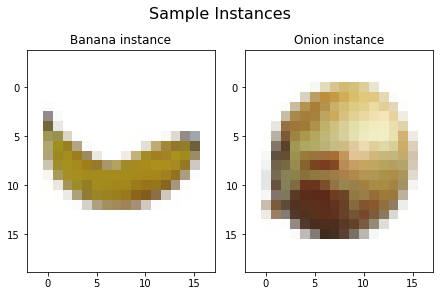

In [7]:
fig, axs = plt.subplots(1, 2, constrained_layout=True)

ax0 = axs[0]
ax0.imshow(banana_images_array[-1].reshape(16, 16, -1), cmap = 'gray')
#ax0.axis('off')
ax0.axis('equal')
ax0.set_title(f'Banana instance')

ax1 = axs[1]
ax1.imshow(onion_images_array[-1].reshape(16, 16, -1), cmap = 'gray')
#ax1.axis('off')
ax1.axis('equal')
ax1.set_title(f'Onion instance')

fig.suptitle('Sample Instances', fontsize=16)
plt.show()

In [8]:
# Constructing full dataset and labels

images = np.array(banana_images_array + onion_images_array)
number_negative_class = 0
number_positive_class = 1
targets = np.array([number_negative_class] * len(banana_images_array) + [number_positive_class] * len(onion_images_array))

In [9]:
targets_count = Counter(targets)
print(f'Total count for dataset: {targets_count}')

Total count for dataset: Counter({0: 490, 1: 438})


In [10]:
# Shuffling dataset
pre_images, pre_targets = shuffle(images, targets, random_state = 0)

In [11]:
print('Splitting dataset')

X_train, X_test, Y_train, Y_test = train_test_split(pre_images, pre_targets, test_size = 0.2, random_state = 10, shuffle = True)

print(f'Training data contains {X_train.shape[0]} instances with distribution {Counter(Y_train)}')
print(f'Test data contains {X_test.shape[0]} instances with distribution {Counter(Y_test)}')

Splitting dataset
Training data contains 742 instances with distribution Counter({0: 393, 1: 349})
Test data contains 186 instances with distribution Counter({0: 97, 1: 89})


Samples


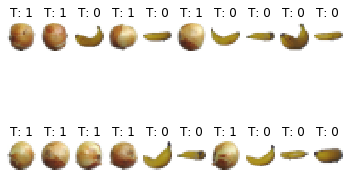

In [12]:
print("Samples")
images_and_labels = list(zip(X_test, Y_test))
for index, (image, label) in enumerate(images_and_labels[10:30]):
    plt.subplot(2, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('T: %i' % label)

In [13]:
# Reshaping dataset
X_train = X_train.reshape(X_train.shape[0], 3, -1)
X_test = X_test.reshape(X_test.shape[0], 3, -1)

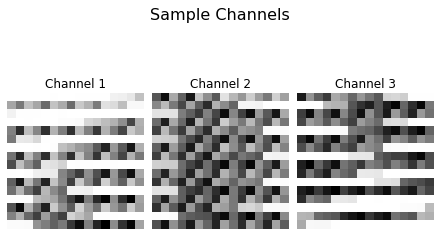

In [14]:
fig, axs = plt.subplots(1, 3, constrained_layout=True)

sample = X_train[35]

axs[0].imshow(sample[0].reshape(16, 16), cmap = 'gray')
axs[0].axis('off')
axs[0].set_title(f'Channel 1')

axs[1].imshow(sample[1].reshape(16, 16), cmap = 'gray')
axs[1].axis('off')
axs[1].set_title(f'Channel 2')

axs[2].imshow(sample[2].reshape(16, 16), cmap = 'gray')
axs[2].axis('off')
axs[2].set_title(f'Channel 3')

fig.suptitle('Sample Channels', fontsize=16)
plt.show()

(0, 4000)

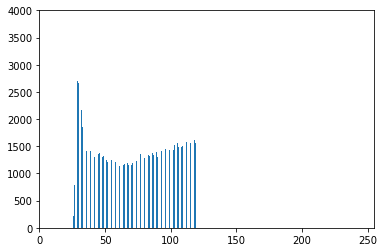

In [15]:
# Quick histogram to manually select binarization threshold
tempi = np.array([x for x in X_train.flatten() if x < 120])
plt.hist(tempi, bins = 250)
plt.xlim((0, 255))
plt.ylim((0, 4_000))

In [16]:
# Binarization via threshold
X_test = X_test < 120
X_train = X_train < 120
X_test = X_test.astype('float64')
X_train = X_train.astype('float64')

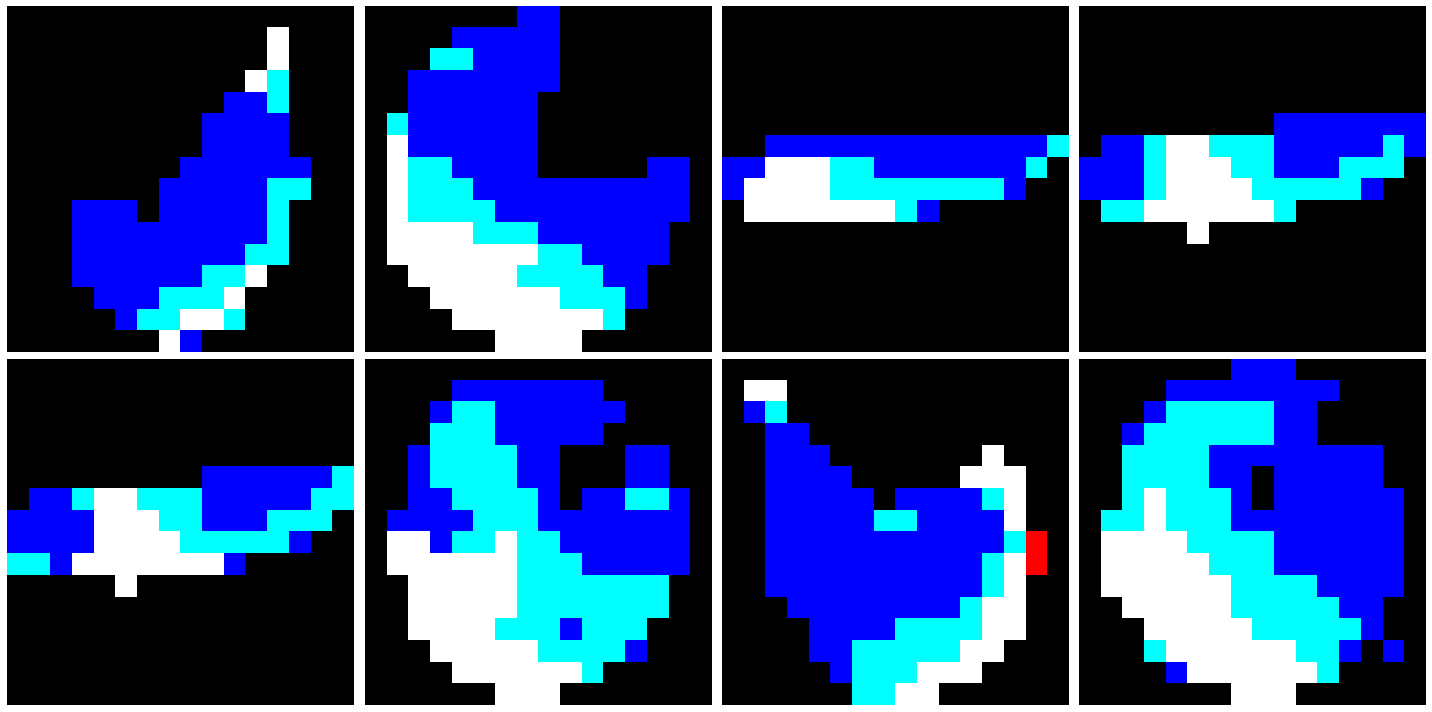

In [17]:
# Sample images after binarization

images_and_labels = list(zip(X_train, Y_train))
fig = plt.figure(figsize = (20,10))
for index, (image, label) in enumerate(images_and_labels[10:18]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image.reshape(16, 16, -1), cmap=plt.cm.gray_r, interpolation='nearest')
plt.tight_layout()
plt.show()

## Fitting the classifier

In [41]:
Q = 8
test_threshold = 0.25
rs = 0
acc = 0
acc_threshold = 0.5
shots = 1024 * 8

splits = 2
repeats = 1

print(f'Training on a {repeats} {splits}-Fold cross validation. For each fold the model is trained to achieve at least {acc_threshold} in accuracy.')
# Training for accuracy instead of epochs simulates a callback

rkf = RepeatedKFold(n_splits = splits, n_repeats = repeats, random_state = 10)
metrics = defaultdict(list)

engine.say("Initiating cross validation")
engine.runAndWait()

for rep, (train_index, test_index) in enumerate(rkf.split(pre_images)):
    engine.say(f"Initiating repetition {rep + 1}")
    engine.runAndWait()
    X_train, X_test = process(pre_images[train_index]), process(pre_images[test_index])
    Y_train, Y_test = pre_targets[train_index], pre_targets[test_index]
    w = X_train[0] # Shortcut for faster training. Could and should be set to random
    acc = 0
    while acc < acc_threshold:
        w, m, weights, ae = fit(qubits = Q, X_train = X_train[:], Y_train = Y_train[:], negative_class = number_negative_class, positive_class = number_positive_class, epochs = 1, shots = shots, threshold = test_threshold, Ip = .8, In = .1, bias = 0.0, w = w)
        classification, readouts = predict(qubits = Q, X_test = X_test, negative_class = number_negative_class, positive_class = number_positive_class, shots = shots, threshold = test_threshold, w = weights[0], bias = 0.0)
        acc = accuracy_score(Y_test, classification)
        ps = precision_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)
        rs = recall_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)
        f1s = f1_score(Y_test, classification, average = 'binary', pos_label = number_negative_class)
        print(f'acc: {acc}, precision: {ps}, recall: {rs}, f1: {f1s}')
        true_labels = np.array([x == number_negative_class for x in Y_test], dtype = 'int')
        loss = 0 if number_negative_class == number_positive_class else log_loss(true_labels, np.array([x == number_negative_class for x in classification], dtype = 'int'))
        #loss = 0 if number_negative_class == number_positive_class else log_loss(Y_test, np.array([x == number_negative_class for x in classification], dtype = 'int'))
    engine.say(f"Saving metrics")
    engine.runAndWait()
    metrics['acc'].append(ae[0])
    metrics['acc_val'].append(acc)
    metrics['loss'].append(ae[1])
    metrics['lossval'].append(loss)
    metrics['precision'].append(ps)
    metrics['recall'].append(rs)
    metrics['f1'].append(f1s)
engine.say("Finished evaluation. Ready to proceed")
engine.runAndWait()

Training on a 1 2-Fold cross validation. For each fold the model is trained to achieve at least 0.5 in accuracy.


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide1 in 160 and change 128 bits
Coincide2 in 146 and change 116 bits
Coincide1 in 81 and change 64 bits
Coincide2 in 67 and change 53 bits
Coincide in 226 and change 22 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 64 and change 6 bits
Coincide in 204 and change 20 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 97 and change 9 bits
Coincide in 179 and change 143 bits
Coincide2 in 67 and change 53 bits
Coincide in 48 and change 4 bits
Coincide1 in 56 and change 5 bits
Coincide2 in 78 and change 7 bits
Coincide in 47 and change 4 bits
Coincide1 in 51 and change 5 bits
Coincide2 in 65 and change 6 bits
Coincide in 65 and change 52 bits
Coincide1 in 69 and change 55 bits
Coincide in 51 and change 5 bits
Coincide1 in 103 and change 10 bits
Coincide2 in 58 and change 5 bits
Coincide in 46 and change 4 bits
Coincide1 in 91 and change 9 bits
Coincide2 in 54 and change 5 bi


acc: 0.8943965517241379, precision: 0.9949494949494949, recall: 0.8040816326530612, f1: 0.8893905191873589


Coincide in 256 and change 25 bits
Coincide1 in 256 and change 25 bits
Coincide2 in 256 and change 25 bits
Coincide in 229 and change 22 bits
Coincide1 in 193 and change 19 bits
Coincide2 in 231 and change 23 bits
Coincide1 in 166 and change 132 bits
Coincide2 in 151 and change 120 bits
Coincide1 in 79 and change 63 bits
Coincide2 in 67 and change 53 bits
Coincide in 201 and change 20 bits
Coincide1 in 73 and change 7 bits
Coincide2 in 43 and change 4 bits
Coincide in 187 and change 149 bits
Coincide1 in 74 and change 59 bits
Coincide in 57 and change 5 bits
Coincide1 in 57 and change 5 bits
Coincide2 in 101 and change 10 bits
Coincide in 56 and change 5 bits
Coincide1 in 66 and change 6 bits
Coincide2 in 59 and change 5 bits
Coincide in 51 and change 5 bits
Coincide1 in 61 and change 6 bits
Coincide2 in 68 and change 6 bits
Coincide in 51 and change 5 bits
Coincide1 in 53 and change 5 bits
Coincide2 in 87 and change 8 bits
Coincide in 51 and change 5 bits
Coincide1 in 51 and change 5 


acc: 0.8599137931034483, precision: 1.0, recall: 0.7346938775510204, f1: 0.8470588235294119


In [20]:
# Save metrics adn weight vector to pickle

#pickle.dump(metrics, open("metrics.p", "wb"))
#pickle.dump(w, open("weight.p", "wb"))

In [21]:
# Load the metrics and weight vector back from the pickle file.

#metrics = pickle.load(open("metrics.p", "rb"))
#w = pickle.load(open("weight.p", "rb"))

In [42]:
# Making a DataFrame from metrics to easy plotting and analysis
df = pd.DataFrame(metrics)
df.describe()

,acc,acc_val,loss,lossval,precision,recall,f1
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.851293,0.877155,5.136171,4.242911,0.997475,0.769388,0.868225
std,0.036574,0.024383,1.263241,0.842158,0.003571,0.049065,0.029933
min,0.825431,0.859914,4.242926,3.647416,0.994949,0.734694,0.847059
25%,0.838362,0.868534,4.689549,3.945163,0.996212,0.752041,0.857642
50%,0.851293,0.877155,5.136171,4.242911,0.997475,0.769388,0.868225
75%,0.864224,0.885776,5.582794,4.540659,0.998737,0.786735,0.878808
max,0.877155,0.894397,6.029417,4.838406,1.000000,0.804082,0.889391


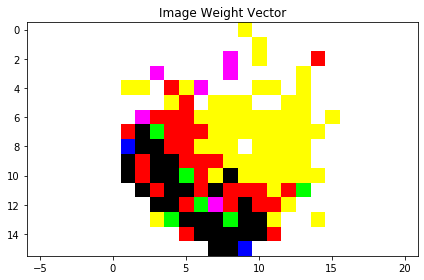

In [43]:
fig, ax = plt.subplots(1, 1)

ax.imshow(w.reshape(16, 16, 3))
#ax.axis('off')
ax.axis('equal')
ax.set_title(f'Image Weight Vector')
plt.tight_layout()
plt.show()

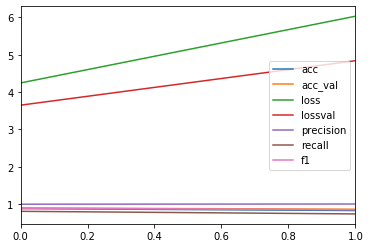

In [44]:
# Quick plot just for data validation
df.plot()

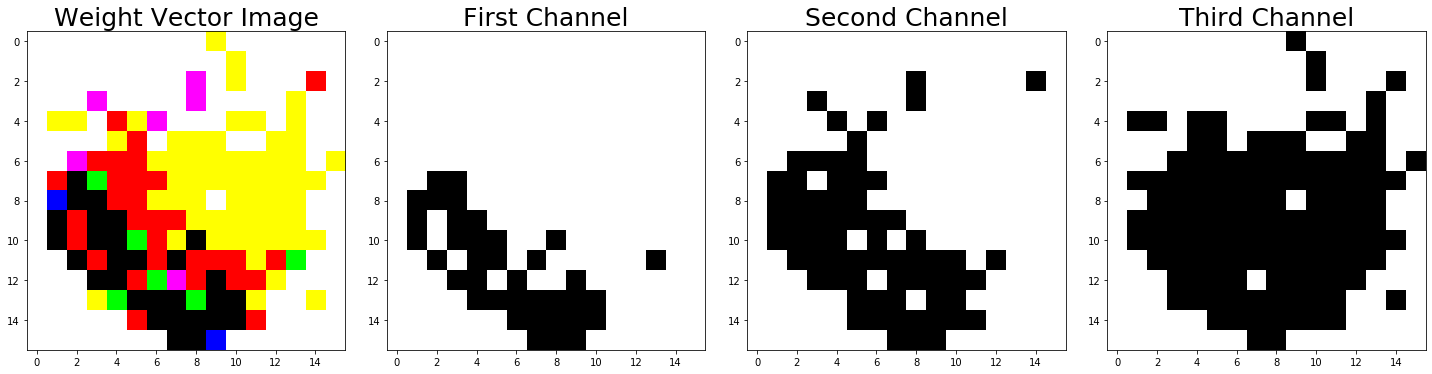

In [45]:
fig = plt.figure(figsize = (20, 10))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

ax1.imshow(w.reshape(16, 16, 3), cmap = plt.cm.gray, interpolation = 'nearest')
ax2.imshow(w.reshape(16, 16, 3)[..., 0], cmap = plt.cm.gray, interpolation = 'nearest')
ax3.imshow(w.reshape(16, 16, 3)[..., 1], cmap = plt.cm.gray, interpolation = 'nearest')
ax4.imshow(w.reshape(16, 16, 3)[..., 2], cmap = plt.cm.gray, interpolation = 'nearest')

ax1.set_title('Weight Vector Image', size=25)
ax2.set_title('First Channel', size=25)
ax3.set_title('Second Channel', size=25)
ax4.set_title('Third Channel', size=25)

plt.tight_layout()
plt.show()

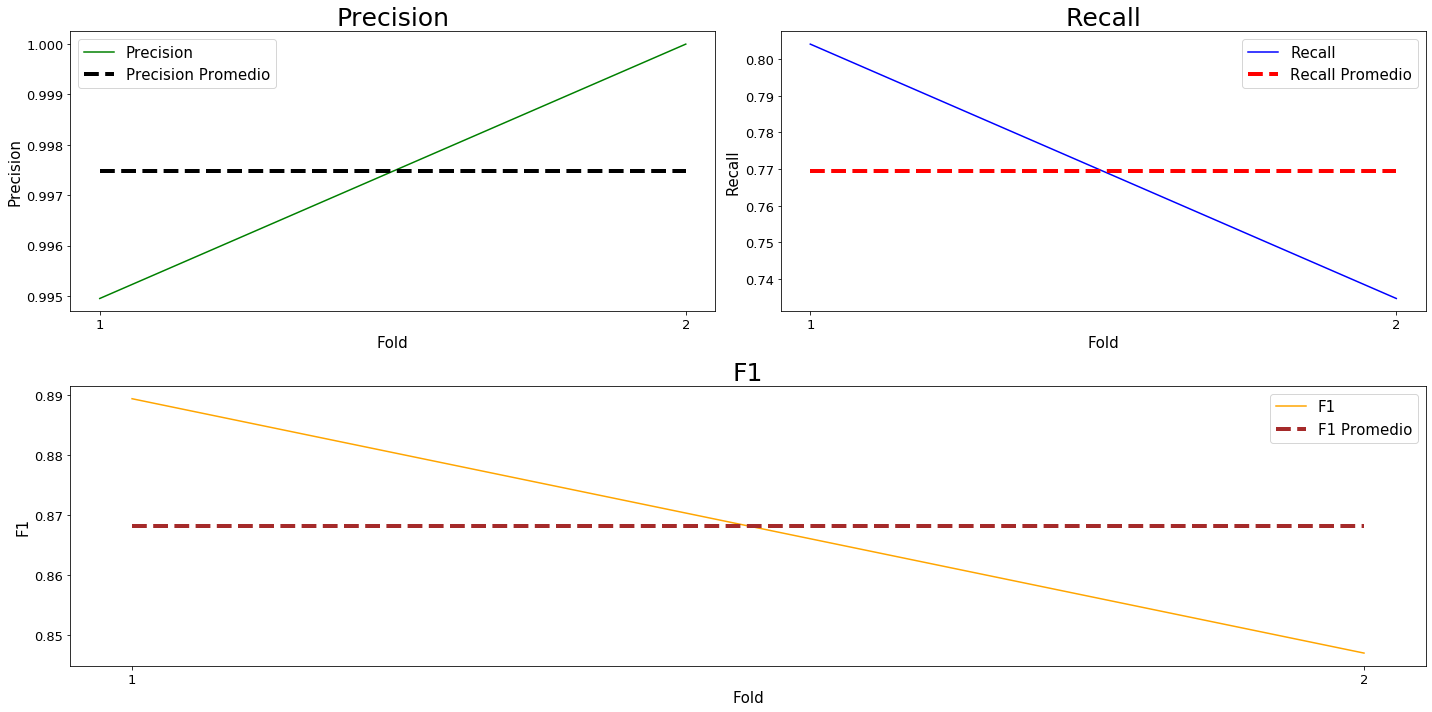

In [48]:
# Precision, Recall and F1 plot
precision = df['precision']
recall = df['recall']
f1 = df['f1']

epochs = range(1, (splits * repeats) + 1)

fig = plt.figure(figsize = (20, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

ax1.plot(epochs, precision, 'g', label = 'Precision')
ax1.plot(epochs, [precision.values.mean()] * len(precision), c = 'black', label = 'Precision Promedio', ls = 'dashed', linewidth = 4)

ax2.plot(epochs, recall, 'b', label = 'Recall')
ax2.plot(epochs, [recall.values.mean()] * len(recall), c = 'red', label = 'Recall Promedio', ls = 'dashed', linewidth = 4)

ax3.plot(epochs, f1, 'orange', label = 'F1')
ax3.plot(epochs, [f1.values.mean()] * len(precision), c = 'brown', label = 'F1 Promedio', ls = 'dashed', linewidth = 4)

ax1.set_title('Precision', size=25)
ax1.set_xlabel('Fold', fontdict = {'fontsize' : 15})
ax1.set_ylabel('Precision', fontdict = {'fontsize' : 15})
ax1.legend(prop={'size': 15})
ax1.set_xticks(ticks = epochs)
ax1.tick_params(labelsize = 13)

ax2.set_title('Recall', size=25)
ax2.set_xlabel('Fold', fontdict = {'fontsize' : 15})
ax2.set_ylabel('Recall', fontdict = {'fontsize' : 15})
ax2.legend(prop={'size': 15})
ax2.set_xticks(ticks = epochs)
ax2.tick_params(labelsize = 13)

ax3.set_title('F1', size=25)
ax3.set_xlabel('Fold', fontdict = {'fontsize' : 15})
ax3.set_ylabel('F1', fontdict = {'fontsize' : 15})
ax3.legend(prop={'size': 15})
ax3.set_xticks(ticks = epochs)
ax3.tick_params(labelsize = 13)
plt.tight_layout()
plt.show()

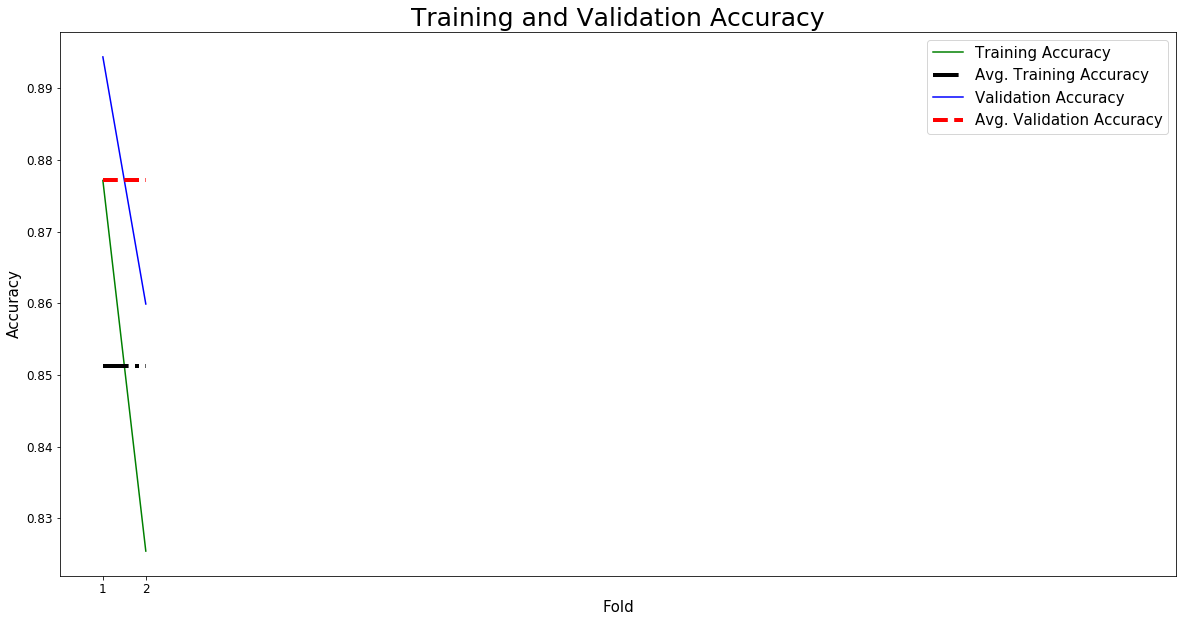

In [49]:
# Accuracy plot
acc = df['acc']
acc_val = df['acc_val']

epochs = range(1, (splits * repeats) + 1)

plt.figure(figsize = (20, 10))
plt.plot(epochs, acc, 'g', label = 'Training Accuracy')
plt.plot(epochs, [acc.values.mean()] * len(acc), 'black', label = 'Avg. Training Accuracy', ls = 'dashdot', linewidth = 4)
plt.plot(epochs, acc_val, 'b', label = 'Validation Accuracy')
plt.plot(epochs, [acc_val.values.mean()] * len(acc_val), 'red', label = 'Avg. Validation Accuracy', ls = 'dashed', linewidth = 4)
plt.title('Training and Validation Accuracy', fontdict = {'fontsize' : 25})
plt.xlabel('Fold', fontdict = {'fontsize' : 15})
plt.ylabel('Accuracy', fontdict = {'fontsize' : 15})
plt.legend()
plt.xlim((0, 26))
plt.xticks(ticks = epochs)
plt.tick_params(labelsize = 12)
plt.legend(prop={'size': 15})
plt.show()

## Predicting and evaluating a single trained classifier

In [94]:
Q = 8
test_threshold = 0.25
rs = 0
acc = 0
shots = 1024 * 8
N = 10 # -1 for full dataset
w, m, weights, ae = fit(qubits = Q, X_train = X_train[:N], Y_train = Y_train[:N], negative_class = number_negative_class, positive_class = number_positive_class, epochs = 1, shots = shots, threshold = test_threshold, Ip = .8, In = .1, bias = 0.0, w = w)


Errors = 0 for accuracy of = 1.0



In [95]:
classification, readouts = predict(qubits = Q, X_test = X_test[:N], negative_class = number_negative_class, positive_class = number_positive_class, shots = shots, threshold = test_threshold, w = weights[0], bias = 0.0)

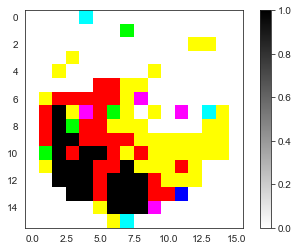

In [99]:
c = plt.imshow(np.array(w).reshape(16, 16, 3)[..., :], cmap = 'gray_r')
plt.colorbar(c)

In [100]:
accuracy, counts, confusion_matriX = evaluate(Y_test, classification, number_negative_class, number_positive_class)
print(f'Accuracy = {accuracy}')
print(f'Counts = {counts}')
print(f'Confusion Matrix = \n{confusion_matriX}')

Accuracy = 0.0
Counts = Counter()
Confusion Matrix = 
[[3. 1.]
 [0. 6.]]


C:\Users\jeff_\Anaconda3\lib\site-packages\ipykernel_launcher.py:326: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


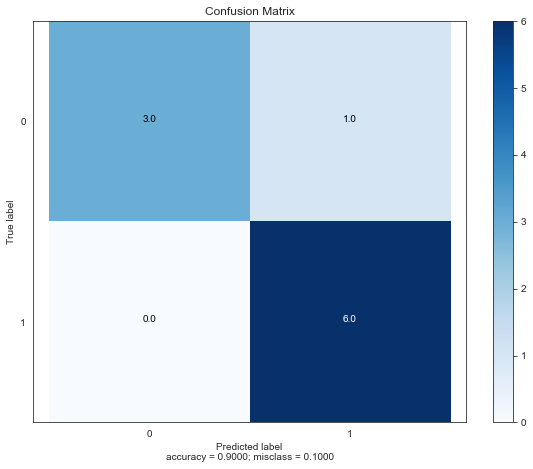

In [101]:
plot_confusion_matrix(confusion_matriX, target_names = np.array([number_negative_class, number_positive_class]), labels = True, normalize = False)

In [102]:
accuracy_score(Y_test[:N], classification)

0.9

In [103]:
precision_score(Y_test[:N], classification, average = 'binary', pos_label = number_negative_class)

1.0

In [104]:
recall_score(Y_test[:N], classification, average = 'binary', pos_label = number_negative_class)

0.75

In [105]:
f1_score(Y_test[:N], classification, average = 'binary', pos_label = number_negative_class)

0.8571428571428571

AUC: 0.875


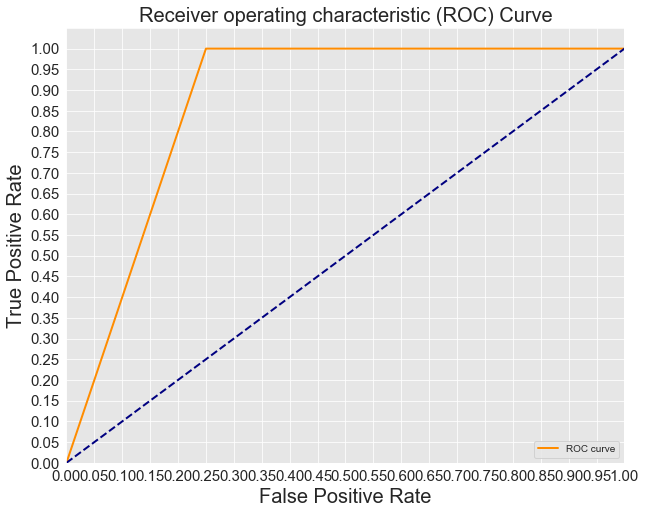

In [106]:
test = [0 if ele == number_negative_class else 1 for ele in Y_test[:N]]
classi = [0 if ele == number_negative_class else 1 for ele in classification]

fpr, tpr, thresholds = roc_curve(test, classi)

def ROC_curve(fpr,tpr):
    # Seaborn's beautiful styling
    sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)], fontsize = 15)
    plt.xticks([i/20.0 for i in range(21)], fontsize = 15)
    plt.xlabel('False Positive Rate', fontsize = 20)
    plt.ylabel('True Positive Rate', fontsize = 20)
    plt.title('Receiver operating characteristic (ROC) Curve', fontsize = 20)
    plt.legend(loc='lower right')
    plt.show()

ROC_curve(fpr,tpr)
sns.set_style('white', {'axes.facecolor': '0.9'})


## Plotting misclassified samples

In [115]:
# Getting a list of misclassifications
fails = np.where(classification != Y_test[:N])[0]

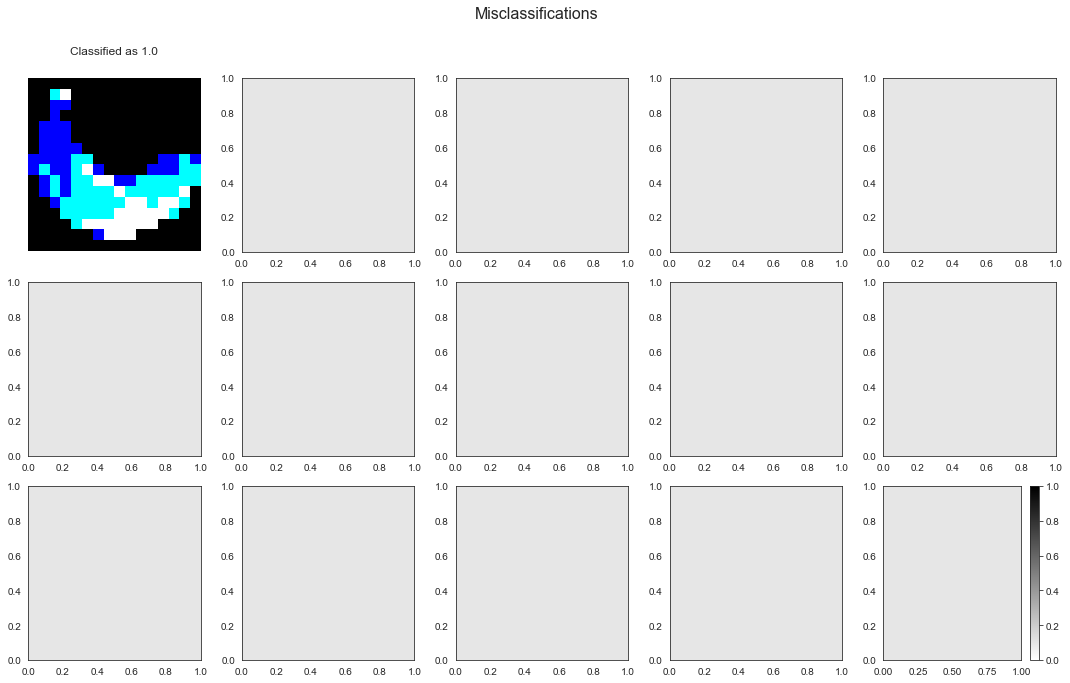

In [116]:
fig, axs = plt.subplots(3, max(5, int(np.ceil(len(fails) / 3))), figsize=(15,9))
count = 0

for i in range(3):
    for j in range(int(np.ceil(len(fails) / 3))):
        ax = axs[i][j]
        
        #c = ax.pcolor(thetas[i + j][1:].reshape(28, 28), cmap = 'gray')
        try:
            c = ax.imshow(np.array(X_test[fails[count]]).reshape(16, 16, 3), cmap = 'gray_r', interpolation='nearest')
            ax.axis('off')
            ax.axis('equal')
            ax.set_title(f'Classified as {classification[fails[count]]}').set_position([0.5, 1.1])
            count += 1
        except IndexError:
            continue

fig.suptitle('Misclassifications', fontsize=16).set_position([0.5, 1.05])
fig.tight_layout()
plt.colorbar(c)
plt.show()

In [80]:
# Since is only one weight vector, I prefer doing a pickle
#filename = 'weights_OvA.txt'
#mode = 'a+'
#save_weight(filename = filename, mode = mode, weight = w)